### **What is Market Anomaly Detection?** <br>
Market anomalies are unusual patterns in financial markets that deviate from normal behavior. These could be:

- Price anomalies: Sudden price jumps/drops without news
- Volume anomalies: Unusual trading volume spikes
- Correlation anomalies: Normal relationships between assets breaking down
- Technical anomalies: Chart patterns that historically signal opportunities

## **1. Objective**
Build a system to detect unusual market behavior (price spikes, volume anomalies, correlation breaks) and visualize alerts in real-time

## **2. Data Pipeline Setup**

In [11]:
!pip install yfinance plotly scikit-learn streamlit pandas numpy


## **3. Data Collection (Simulating Real-Time with Yahoo Finance)**

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

ticker = 'AAPL'
data = yf.download(tickers=ticker, period='1d', interval='1m')
data.dropna(inplace=True)
data['returns'] = data['Close'].pct_change().fillna(0)
data.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Datetime,,,,,,
2025-05-23 19:55:00+00:00,195.279999,195.360001,195.029999,195.320007,457306,-0.000249
2025-05-23 19:56:00+00:00,195.511307,195.630005,195.259995,195.284393,429961,0.001184
2025-05-23 19:57:00+00:00,195.404999,195.520004,195.320007,195.520004,462225,-0.000544
2025-05-23 19:58:00+00:00,195.544998,195.600006,195.389999,195.410004,635039,0.000716
2025-05-23 19:59:00+00:00,195.339996,195.544998,195.140106,195.539993,1370945,-0.001048


In [13]:
# Save the downloaded 1-minute intraday data to CSV
data.to_csv("AAPL_intraday_1min.csv")

print("✅ Intraday data saved as 'AAPL_intraday_1min.csv'")

✅ Intraday data saved as 'AAPL_intraday_1min.csv'


## **4. Anomaly Detection**
4.1 Isolation Forest for Price Outliers

In [14]:
from sklearn.ensemble import IsolationForest

model_iso = IsolationForest(contamination=0.01, random_state=42)
data['anomaly_price'] = model_iso.fit_predict(data[['Close']])

4.2 Volume Spike Detection

In [20]:
print(type(data['Volume']))          # should be <class 'pandas.core.series.Series'>
print(type(data['mean_vol']))        # should be <class 'pandas.core.series.Series'>
print(data[['Volume', 'mean_vol']].head())  # quick inspection


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Price                       Volume mean_vol
Ticker                        AAPL         
Datetime                                   
2025-05-23 13:30:00+00:00  8294792      NaN
2025-05-23 13:31:00+00:00   810703      NaN
2025-05-23 13:32:00+00:00   734901      NaN
2025-05-23 13:33:00+00:00   640558      NaN
2025-05-23 13:34:00+00:00   422567      NaN


In [21]:
# Flatten MultiIndex columns
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

In [22]:
print(data.columns)

Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL',
       'returns_', 'anomaly_price_', 'mean_vol_'],
      dtype='object')


In [23]:
# Use the correct column name after flattening
data['mean_vol'] = data['Volume_AAPL'].rolling(window=10).mean().bfill()
data['vol_spike'] = (data['Volume_AAPL'] > 3 * data['mean_vol']).astype(int)

In [24]:
# ✅ Use the correct volume column after flattening
data['Volume_AAPL'] = pd.to_numeric(data['Volume_AAPL'], errors='coerce')
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

# ✅ STEP 1: Calculate mean volume
mean_vol = data['Volume_AAPL'].rolling(window=10).mean()

# ✅ STEP 2: Backfill NaNs
mean_vol = mean_vol.bfill()

# ✅ STEP 3: Align the rolling series with the main DataFrame index
mean_vol = mean_vol.loc[data.index]

# ✅ STEP 4: Compute volume spike
data['vol_spike'] = (data['Volume_AAPL'] > 3 * mean_vol).astype(int)

4.3 Z-Score for Price Volatility

In [26]:
window = 20
data['z_score'] = (data['Close_AAPL'] - data['Close_AAPL'].rolling(window).mean()) / data['Close_AAPL'].rolling(window).std()
data['z_anomaly'] = (abs(data['z_score']) > 3).astype(int)


## **5. Visualization with Plotly**

In [9]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [28]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close_AAPL'], mode='lines', name='Close_AAPL'))
fig.add_trace(go.Scatter(x=data[data['anomaly_price_']==-1].index,
                         y=data[data['anomaly_price_']==-1]['Close_AAPL'],
                         mode='markers', name='Price Anomaly',
                         marker=dict(color='red', size=6)))
fig.update_layout(title=f"{ticker} - Price with Anomalies", xaxis_title='Time', yaxis_title='Price')
fig.show()


## **6. Alerts Table**

In [30]:
alerts = data[(data['anomaly_price_']==-1) | (data['vol_spike']==1) | (data['z_anomaly']==1)]
alerts[['Close_AAPL', 'Volume_AAPL', 'anomaly_price_', 'vol_spike', 'z_anomaly']].tail(10)

,Close_AAPL,Volume_AAPL,anomaly_price_,vol_spike,z_anomaly
Datetime,,,,,
2025-05-23 13:30:00+00:00,195.384995,8294792,1,1,0
2025-05-23 14:25:00+00:00,197.539993,246592,-1,0,0
2025-05-23 14:26:00+00:00,197.399994,293911,-1,0,0
2025-05-23 14:27:00+00:00,197.490005,189401,-1,0,0
2025-05-23 16:04:00+00:00,195.910004,287771,1,1,0
2025-05-23 16:25:00+00:00,196.240005,208037,1,0,1
2025-05-23 18:20:00+00:00,195.600006,792450,1,1,0
2025-05-23 19:26:00+00:00,195.210007,827875,1,1,0
2025-05-23 19:27:00+00:00,195.149902,182985,-1,0,0


In [31]:
# Save the alerts table to a CSV file
alerts[['Close_AAPL', 'Volume_AAPL', 'anomaly_price_', 'vol_spike', 'z_anomaly']].to_csv("market_anomaly_alerts.csv", index=True)

print("📁 Alerts table saved as 'market_anomaly_alerts.csv'")

📁 Alerts table saved as 'market_anomaly_alerts.csv'


## **7. Backtesting Strategy (Signal Validation)**

<Axes: title={'center': '📈 Cumulative Returns from Anomaly-Based Strategy'}, xlabel='Datetime'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



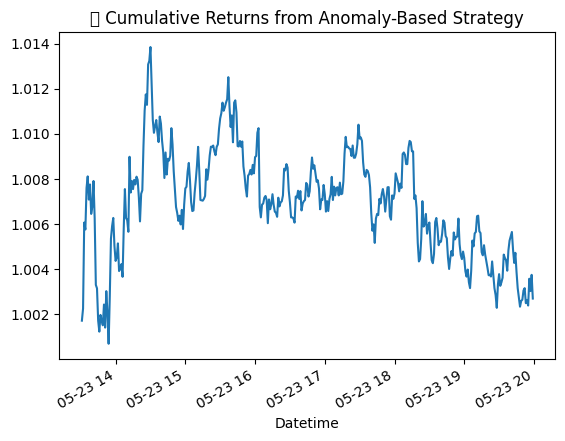

In [34]:
data['position'] = np.where(data['anomaly_price_'] == -1, -1, 1)
data['returns_strategy'] = data['returns_'] * data['position'].shift(1)
cumulative_returns = (1 + data['returns_strategy']).cumprod()

cumulative_returns.plot(title="📈 Cumulative Returns from Anomaly-Based Strategy")
